<a href="https://colab.research.google.com/github/Jaewon45/ESAA_2022/blob/main/1209_CNN_ImgClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch4. 4-5 pg. 182-211

## 04. 위성 이미지 분류
### 4-1. 텐서플로 데이터셋 로드
- EuroSAT 데이터셋 : 인공위성에서 지표면을 촬영한 이미지와 토지이용분류 값

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

import tensorflow_datasets as tfds

In [ ]:
DATA_DIR = 'dataset/'
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]','train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir = DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incompleteASXEIQ/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

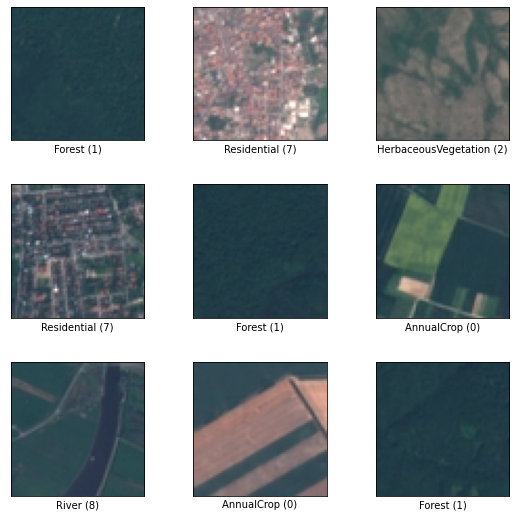

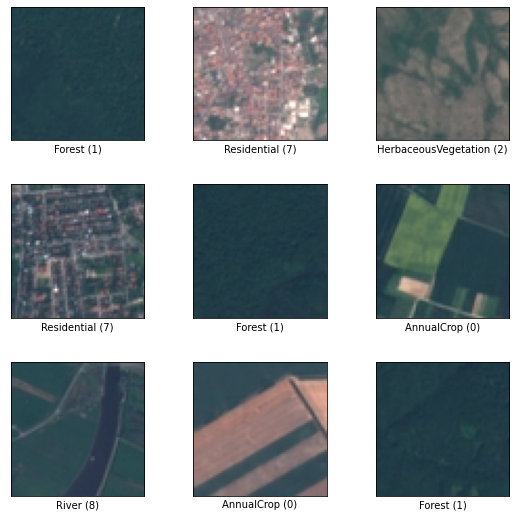

In [ ]:
# 데이터 확인
tfds.show_examples(train_ds, info)

image  label
0  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
1  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
2  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
3  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
4  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
5  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
6  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
7  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
8  [[[135, 127, 124], [135, 127, 124], [132, 127,...      2
9  [[[40, 55, 74], [40, 55, 74], [41, 56, 75], [3...      9
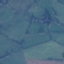
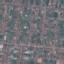
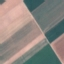
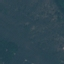
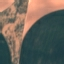
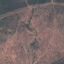
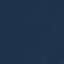
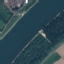
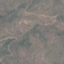
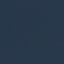

In [ ]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
# 목표 클래스의 개수
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [ ]:
# 숫자 레이블을 활용해 문자열 메타데이터로 변환
print(info.features['label'].int2str(6))

PermanentCrop


### 4-2. 데이터전처리
- 텐서플로 연산은 float32 숫자값을 사용
- map 함수 사용시 num_parallel_calls 옵션을 AUTOTUNE으로 지정하면 텐서플로 병렬연산 처리를 자동으로 최적화해 하드웨어 리소스를 병렬로 매핑하여 처리
- prefetch()는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 하도록 시스템을 조율, 병렬 처리를 통해 훈련시간 단축

In [ ]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64 # 가져온 데이터에서 64개의 데이터를 랜덤하게 선택해 하나의 배치를 구성
BUFFER_SIZE = 1000 # 처음 1000개의 데이터를 가져옴

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32)/255 #0~1 정규화, float32 변환
  return image, label


train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### 4-3. 모델 훈련 및 검증

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():
    
    model = tf.keras.Sequential([

        #Convolution 층
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        #Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

model = build_model()

In [ ]:
#모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#모델 훈련
history = model.fit(train_data, validation_data=valid_data, epochs=10)


Epoch 1/10
338/338 [==============================] - 273s 803ms/step - loss: 1.5526 - accuracy: 0.4513 - val_loss: 1.7085 - val_accuracy: 0.4281
Epoch 2/10
338/338 [==============================] - 230s 680ms/step - loss: 1.1733 - accuracy: 0.5801 - val_loss: 0.8911 - val_accuracy: 0.6880
Epoch 3/10
338/338 [==============================] - 238s 704ms/step - loss: 1.0372 - accuracy: 0.6343 - val_loss: 0.7519 - val_accuracy: 0.7343
Epoch 4/10
338/338 [==============================] - 237s 701ms/step - loss: 0.9147 - accuracy: 0.6768 - val_loss: 0.6585 - val_accuracy: 0.7909
Epoch 5/10
338/338 [==============================] - 232s 686ms/step - loss: 0.8153 - accuracy: 0.7127 - val_loss: 0.6445 - val_accuracy: 0.7902
Epoch 6/10
338/338 [==============================] - 197s 583ms/step - loss: 0.7590 - accuracy: 0.7365 - val_loss: 0.5736 - val_accuracy: 0.8044
Epoch 7/10
338/338 [==============================] - 182s 539ms/step - loss: 0.6731 - accuracy: 0.7686 - val_loss: 0.5442 -

In [ ]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].plot(range(1, epoch+1), loss, label='Training')
    axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch+1), acc, label='Training')
    axes[1].plot(range(1, epoch+1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

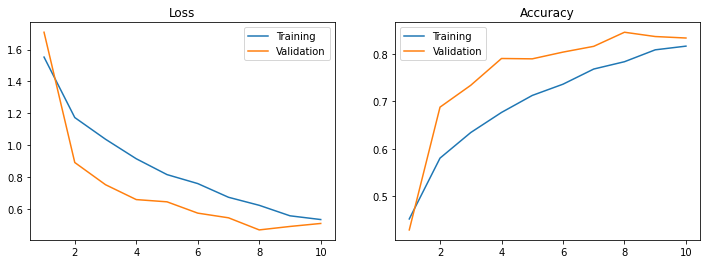

In [ ]:
#손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 10)

### 4-4. 데이터 증강
- 데이터 증강(data augmentation) : 과대적합을 해소하고 모델의 일반화된 Robust한 성능을 확보하기 위한 기법, 이미지 데이터에 여러가지 변형을 주어서 훈련 데이터의 다양성을 확보해 새로운 데이터에 대한 예측력을 강화함

Text(0.5, 1.0, 'River')

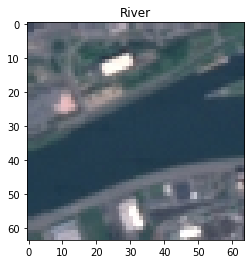

In [ ]:
# 샘플이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

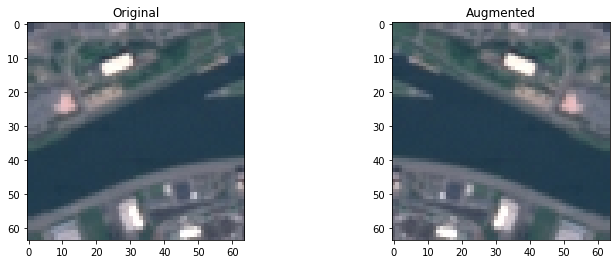

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

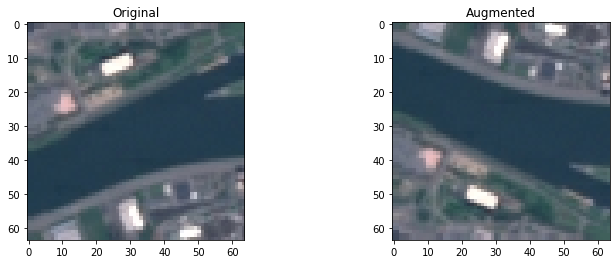

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

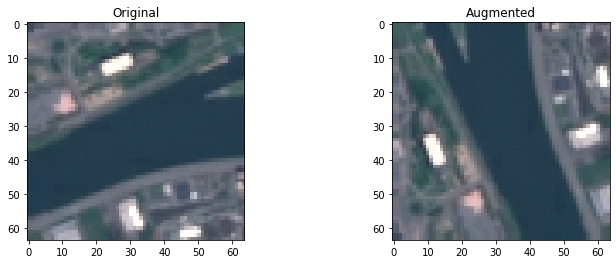

In [ ]:
# 회전 - 반시계방향 90도
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

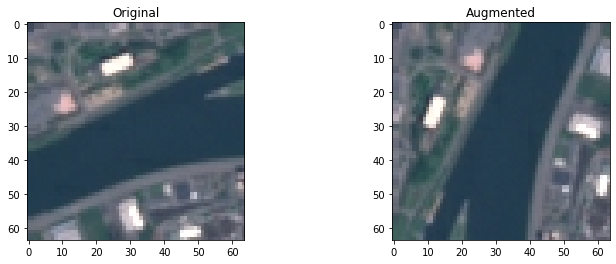

In [ ]:
# transpose
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

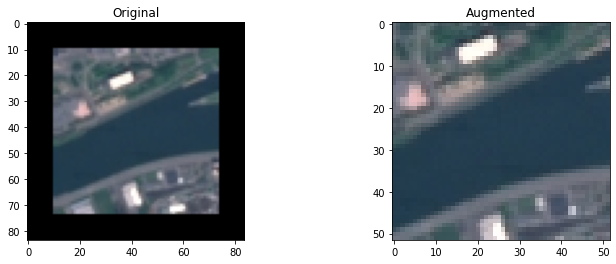

In [ ]:
# 이미지 자르기 1 - 중심에서 일정부분 잘라냄
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

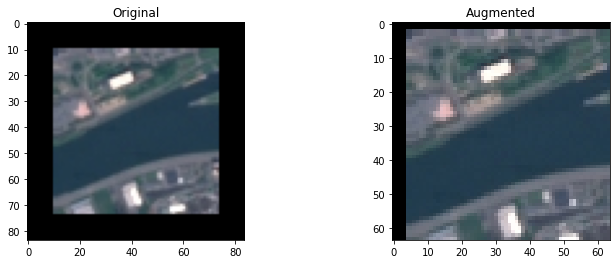

In [ ]:
# 이미지 자르기 2
image = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20) # 사이즈 키우기
crop2 = tf.image.random_crop(image, size=[64, 64, 3])
plot_augmentation(image, crop2)

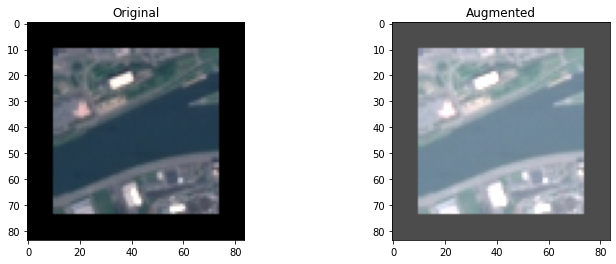

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

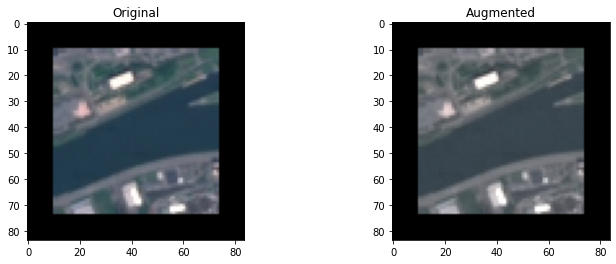

In [ ]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

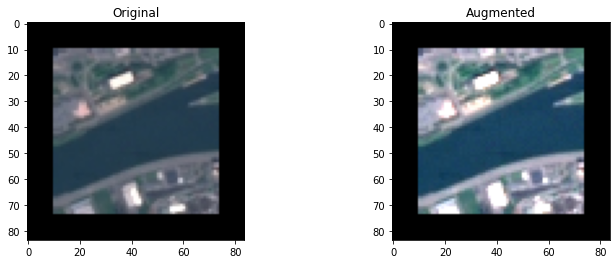

In [ ]:
# 이미지 대비
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 이미지 증강 전처리
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255. # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, validation_data=valid_aug, epochs=10)

Epoch 1/10
338/338 [==============================] - 189s 556ms/step - loss: 1.8595 - accuracy: 0.3158 - val_loss: 1.8316 - val_accuracy: 0.3500
Epoch 2/10
338/338 [==============================] - 186s 550ms/step - loss: 1.5216 - accuracy: 0.4137 - val_loss: 1.3129 - val_accuracy: 0.5422
Epoch 3/10
338/338 [==============================] - 184s 543ms/step - loss: 1.3913 - accuracy: 0.4675 - val_loss: 1.2122 - val_accuracy: 0.5617
Epoch 4/10
338/338 [==============================] - 184s 543ms/step - loss: 1.2976 - accuracy: 0.5125 - val_loss: 1.2357 - val_accuracy: 0.5554
Epoch 5/10
338/338 [==============================] - 183s 541ms/step - loss: 1.1990 - accuracy: 0.5580 - val_loss: 1.0327 - val_accuracy: 0.6241
Epoch 6/10
338/338 [==============================] - 185s 546ms/step - loss: 1.1444 - accuracy: 0.5784 - val_loss: 0.9261 - val_accuracy: 0.6831
Epoch 7/10
338/338 [==============================] - 191s 565ms/step - loss: 1.0924 - accuracy: 0.5980 - val_loss: 0.9441 -

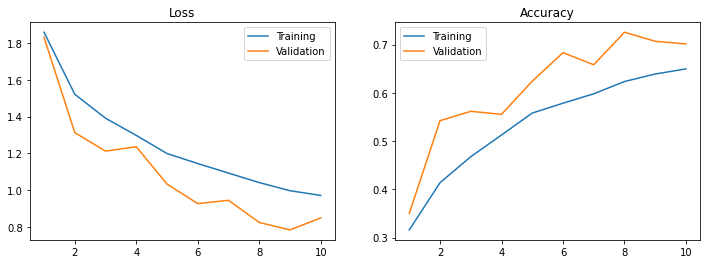

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 10)

- 증강 전후 모델의 성능 자체는 큰 차이가 없지만, 훈련 셋과 검증 셋에 대한 손실함수는 계속 줄어들고 정확도는 우상향하며 개선됨 - 과대적합 문제가 상당히 해소됨

### 4-5. ResNet 사전학습모델
- 이미지넷 경진 대회에서 우승한 모델
- 사전에 방대한 이미지로 훈련받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델을 구성 => 전이 학습(transfer learning)

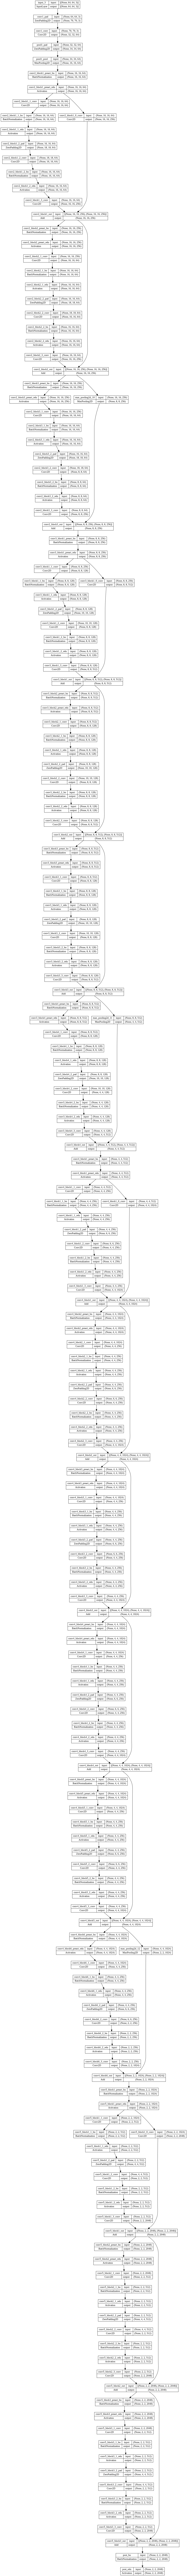

In [ ]:
# pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top = False, 
                              # ^ 이미지넷 경진 대회에 맞는 분류기이므로 제거, 문제에 맞는 최종 분류기를 대체해서 추가
                              weights='imagenet', 
                              input_shape=[64, 64, 3]) # 사용하는 데이터 크기에 맞게 지정

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable=False

# 모델 구조 시각화
from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes = True, show_layer_names = True, to_file = 'resnet50.png')

In [ ]:
# TOP 층에 Classifier 추가

def build_transfer_classifier():
  model = tf.keras.Sequential([
      
      # pre-trained base
      pre_trained_base,

      # classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),                           
  ])

  return model

# 모델 구조
tc_model = build_transfer_classifier()
tc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 10)               

## 05. 개/고양이 분류
- 이미지 파일 사용시 컴퓨터 메모리 또는 그래픽 카드 메모리가 부족한 상황 자주 발생
- 이미지 데이터셋을 32장, 64장, 128장 등 배치(batch) 단위로 나눈 다음, 배치 한개를 읽어와 딥러닝 모델에 주입시 메모리 부담 없이 학습 가능
- `ImageDataGenerater` 함수 : 데이터셋을 배치 단위의 여러 부분으로 나누고 반복 객체(iterator)를 통해서 각 배치를 한개씩 모델에 임력하여 훈련

### 5-1. 분석 준비

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축 파일의 위치 
drive_path = '/content/drive/MyDrive/esaa'
source_filename = drive_path + '/cat-and-dog.zip'

# 저장할 경로
extract_folder = 'dataset/' # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [ ]:
# 훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + 'training_set/training_set'
valid_dir = extract_folder + 'test_set/test_set'
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


### 5-2. 모델 학습

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.))
image_gen

- 이미지 제너레이터 객체에 flow_from_dictionary 함수를 적용하면, 지정한 폴더에서 이미지를 가져와 반복 이터레이션이 가능하도록 데이터셋을 처리

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size=32,
                                          target_size=(224, 224),
                                          classes=['cats', 'dogs'],
                                          class_mode = 'binary',
                                          seed=2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-8-901e0efeb52a>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


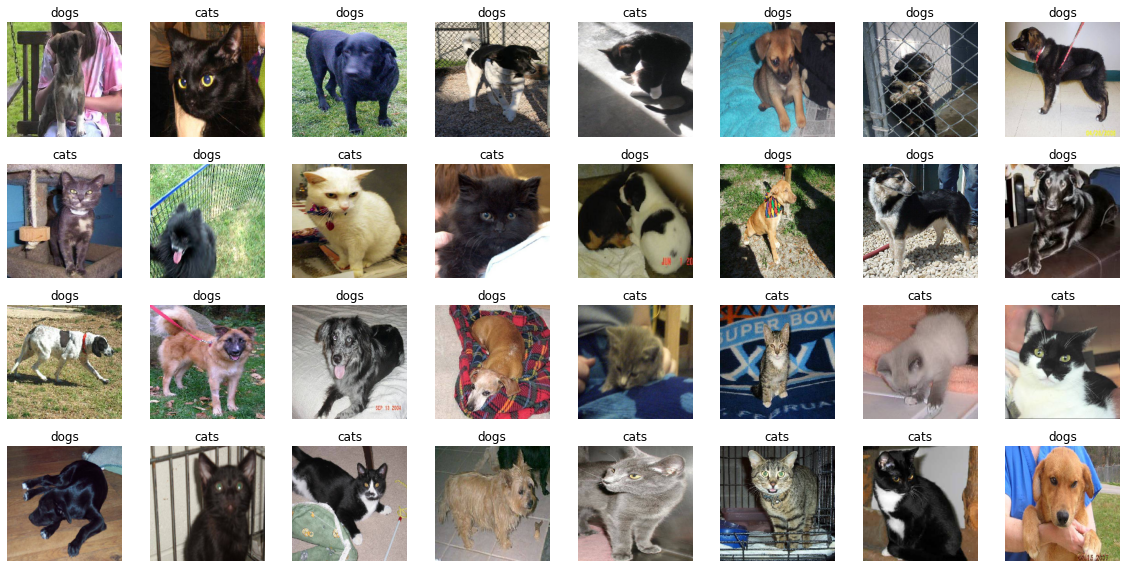

In [ ]:
# 샘플 이미지 출력
class_labels = ['cats','dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16,8))
for i in range(32):

    ax = plt.subplot(4, 8, i+1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 : 배치정규화-합성곱-풀링
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),

        # Classifier 출력층
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')        
    ])

    return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=5)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 1113s 4s/step - loss: 21.3050 - accuracy: 0.5119 - val_loss: 0.6893 - val_accuracy: 0.5447
Epoch 2/5
251/251 [==============================] - 1078s 4s/step - loss: 0.6899 - accuracy: 0.5267 - val_loss: 0.6862 - val_accuracy: 0.5512
Epoch 3/5
251/251 [==============================] - 1076s 4s/step - loss: 0.6893 - accuracy: 0.5263 - val_loss: 0.6712 - val_accuracy: 0.5630
Epoch 4/5
251/251 [==============================] - 1074s 4s/step - loss: 0.6895 - accuracy: 0.5141 - val_loss: 0.6890 - val_accuracy: 0.5393
Epoch 5/5
251/251 [==============================] - 1081s 4s/step - loss: 0.6923 - accuracy: 0.4964 - val_loss: 0.6923 - val_accuracy: 0.5166


In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 5)

### 5-4. 데이터 증강

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255.,
                                   horizontal_flip=True, # 좌우 방향으로 뒤집음
                                   rotation_range=30, # 회전 최대각
                                   shear_range=0.15, # 반시계 방향으로 밀리도록 변형
                                   zoom_range=0.3) # 줌으로 확대

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  classes=['cats','dogs'],
                                                  class_mode='binary',
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=5)

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(aug_history, 5)

- epoch를 늘리면 더 개선될 것

- 